In [1]:
import os
from glob import glob

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.utils.data as data
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import numpy as np
from PIL import Image

# Hyperparameter

In [13]:
print('Num_GPU :', torch.cuda.device_count())

no_cuda = False
use_cuda = not no_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
Tensor = torch.cuda.FloatTensor if use_cuda else torch.Tensor

params = {
    'batch_size':70 * torch.cuda.device_count(),
    'test_batch_size':70 * torch.cuda.device_count(),
    'input_size':128,
    'resize_scale':134,
    'crop_size':128,
    'fliplr':True,
    #model params
    'epoch_count':1,
    'epochs':100,
    'log_interval':2,
    'lr':0.0002,
    'beta':3,
    'tau':0.6,
    'threshold':0.5,
    'lamda_u':1,
    'sim_dataroot':'C:/Users/IVCL/Desktop/duck/aug_no_circle_margin',
    'real_dataroot':'C:/Users/IVCL/Desktop/duck/real',
    'aug_real_dataroot':'C:/Users/IVCL/Desktop/duck/aug_real',
}

Num_GPU : 2


# Utils

In [3]:
def to_np(x):
    return x.data.cpu().numpy()
        
def plot_train_result(test_image, epoch, save=False,  show=True, fig_size=(15, 15)):
    plt.figure(figsize=fig_size)
    imgs = [to_np(test_image[0]), to_np(test_image[1]), to_np(test_image[2]), to_np(test_image[3]), to_np(test_image[4])]
    title = ["Test Image", "Test Rec", "Predicted Rec", "Test Mask", "Predicted Mask"]
        
    for i in range(0,3):
        plt.subplot(1, 5, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        img = imgs[i]
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min())).transpose(1, 2, 0).astype(np.uint8)
        plt.imshow(img)
        plt.axis('off')

    for i in range(3, 5):
        plt.subplot(1, 5, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        img = imgs[i]
        img = img.squeeze()
        img = (((img - img.min()) * 255) / (img.max() - img.min()))
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    
    # save figure
    if save:
        save_fn = './img_per_epoch/epoch_{:d}'.format(epoch+1) + '.png'
        fig.savefig(save_fn)

    if show:
        plt.show()
    else:
        plt.close()

# Model

In [4]:
class Net(nn.Module):
    def __init__(self, d=64):
        super(Net,self).__init__()
        #f1
        self.conv1 = nn.Conv2d(3, d, 5, 2, 2)
        self.bn1 = nn.BatchNorm2d(d)
        self.relu1 = nn.LeakyReLU(inplace=True)

        self.conv2 = nn.Conv2d(3, d, 5, 2, 2)
        self.bn2 = nn.BatchNorm2d(d)
        self.relu2 = nn.LeakyReLU(inplace=True)
       
        #f2
        self.conv3 = nn.Conv2d(d*2, d*2, 5, 2, 2)
        self.bn3 = nn.BatchNorm2d(d*2)
        self.relu3 = nn.LeakyReLU(inplace=True)

        self.conv4 = nn.Conv2d(d*2, d*2, 5, 2, 2)
        self.bn4 = nn.BatchNorm2d(d*2)
        self.relu4 = nn.LeakyReLU(inplace=True)
       
        #f3
        self.conv5 = nn.Conv2d(d*4, d*2, 5, 2, 2)
        self.bn5 = nn.BatchNorm2d(d*2)
        self.relu5 = nn.LeakyReLU(inplace=True)

        self.conv6 = nn.Conv2d(d*4, d*2, 5, 2, 2)
        self.bn6 = nn.BatchNorm2d(d*2)
        self.relu6 = nn.LeakyReLU(inplace=True)
       
        #f4
        self.conv7 = nn.Conv2d(d*4, d*4, 5, 2, 2)
        self.bn7 = nn.BatchNorm2d(d*4)
        self.relu7 = nn.LeakyReLU(inplace=True)

        self.conv8 = nn.Conv2d(d*4, d*4, 5, 2, 2)
        self.bn8 = nn.BatchNorm2d(d*4)
        self.relu8 = nn.LeakyReLU(inplace=True)
       
        #encode
        self.fc1 = nn.Linear(int(params['input_size']/16)*int(params['input_size']/16)*d*8, d*4)
        self.fc2 = nn.Linear(d*4,int(params['input_size']/16)*int(params['input_size']/16)*d*4)
        
        #d1
        self.conv9 = nn.ConvTranspose2d(d*4, d*2, 5, 2, 2, 1)
        self.bn9 = nn.BatchNorm2d(d*2)
        self.relu9 = nn.LeakyReLU(inplace=True)
        
        #d1_uni
        self.conv10 = nn.ConvTranspose2d(d*4, d*4, 5, 1, 2)
        self.bn10 = nn.BatchNorm2d(d*4)
        self.relu10 = nn.LeakyReLU(inplace=True)
        
        #d2
        self.conv11 = nn.ConvTranspose2d(d*4, d*2, 5, 2, 2, 1)
        self.bn11 = nn.BatchNorm2d(d*2)
        self.relu11 = nn.LeakyReLU(inplace=True)       

        #d2_uni
        self.conv12 = nn.Conv2d(d*4, d*4, 5, 1, 2)
        self.bn12 = nn.BatchNorm2d(d*4)
        self.relu12 = nn.LeakyReLU(inplace=True)  

        #d3
        self.conv13 = nn.ConvTranspose2d(d*4, d, 5, 2, 2, 1)
        self.bn13 = nn.BatchNorm2d(d)
        self.relu13 = nn.LeakyReLU(inplace=True)          

        #d3_uni
        self.conv14 = nn.Conv2d(d*2, d*2, 5, 1, 2)
        self.bn14 = nn.BatchNorm2d(d*2)
        self.relu14 = nn.LeakyReLU(inplace=True) 
        
        #decode
        self.conv15 = nn.ConvTranspose2d(d*2, 3, 5, 2, 2, 1)
        self.conv16 = nn.ConvTranspose2d(d*2, 1, 5, 2, 2, 1)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def forward(self, x):
        f1_1 = self.relu1(self.bn1(self.conv1(x))) #64x64x64
        f1_2 = self.relu2(self.bn2(self.conv2(x))) #64x64x64
        
        f1 = torch.cat((f1_1, f1_2), 1) #128x64x64
        
        f2_1 = self.relu3(self.bn3(self.conv3(f1))) #128x32x32
        f2_2 = self.relu4(self.bn4(self.conv4(f1))) #128x32x32

        f2 = torch.cat((f2_1, f2_2), 1) #256x32x32
        
        f3_1 = self.relu5(self.bn5(self.conv5(f2))) #128x16x16
        f3_2 = self.relu6(self.bn6(self.conv6(f2))) #128x16x16
        
        f3 = torch.cat((f3_1, f3_2), 1) #256x16x16

        f4_1 = self.relu7(self.bn7(self.conv7(f3))) #256x8x8
        f4_2 = self.relu8(self.bn8(self.conv8(f3))) #256x8x8
        
        f4 = torch.cat((f4_1, f4_2), 1) #512x8x8

        x = f4.view(f4.size(0), -1)
        encode = self.fc1(x) #256
        
        d1 = self.fc2(encode) #256x8x8
        d1 = self.relu9(self.bn9(self.conv9(d1.view(-1,256,int(params['input_size']/16),int(params['input_size']/16))))) #128x16x16
             
        d1_uni = torch.cat((d1, f3_2), 1) #256x16x16
        d1_uni = self.relu10(self.bn10(self.conv10(d1_uni))) #256x16x16
        
        d2 = self.relu11(self.bn11(self.conv11(d1_uni))) #128x32x32
        
        d2_uni = torch.cat((d2, f2_2), 1) #256x32x32
        d2_uni = self.relu12(self.bn12(self.conv12(d2_uni))) #256x32x32
        
        d3 = self.relu13(self.bn13(self.conv13(d2_uni))) #64x64x64
        
        d3_uni = torch.cat((d3, f1_2), 1) #128x64x64
        d3_uni = self.relu14(self.bn14(self.conv14(d3_uni))) #128x64x64

        rec = self.conv15(d3_uni) #3x128x128
        mask = self.conv16(d3_uni) #1x128x128
        
        return torch.tanh(rec), torch.sigmoid(mask)

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# Preprocess

In [5]:
class DatasetFromFolder(data.Dataset):
    def __init__(self, image_dir, subfolder='train', transform=None, resize_scale=None, crop_size=None, fliplr=False):
        super(DatasetFromFolder, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_path = os.path.join(self.input_path, 'image')
        self.mask_path = os.path.join(self.input_path, 'label')
        self.rec_path = os.path.join(self.input_path, 'rec')
        
        self.image_filenames = [x for x in sorted(os.listdir(self.image_path))]
        self.transform = transform
        
        self.resize_scale = resize_scale
        self.crop_size = crop_size
        self.fliplr = fliplr

    def __getitem__(self, index):
        # Load Image
        img_fn = os.path.join(self.image_path, self.image_filenames[index])
        rec_fn = os.path.join(self.rec_path, self.image_filenames[index])
        mask_fn = os.path.join(self.mask_path, self.image_filenames[index])
        
        img = Image.open(img_fn).convert('RGB')
        rec = Image.open(rec_fn).convert('RGB')
        mask = Image.open(mask_fn)
        
        seed = random.randint(1, 1000)
        random.seed(seed)
                          
        # preprocessing
        if self.resize_scale:
            img = img.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            rec = rec.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            mask = mask.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            
        if self.crop_size:
            x = random.randint(0, self.resize_scale - self.crop_size + 1)
            y = random.randint(0, self.resize_scale - self.crop_size + 1)
            img = img.crop((x, y, x + self.crop_size, y + self.crop_size))
            rec = rec.crop((x, y, x + self.crop_size, y + self.crop_size))
            mask = mask.crop((x, y, x + self.crop_size, y + self.crop_size))
            
        if self.fliplr:
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
                rec = rec.transpose(Image.FLIP_LEFT_RIGHT)
                mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        
        mask = np.array(mask)
        mask = np.where(mask>0,1.0,0)
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze_(0).float()  
        
        if self.transform is not None:
            img = self.transform(img)
            rec = self.transform(rec)
        
        return img, rec, mask

    def __len__(self):
        return len(self.image_filenames)

In [6]:
class DatasetFromFolder2(data.Dataset):
    def __init__(self, image_dir, aug_image_dir, subfolder='val', transform=None, resize_scale=None, crop_size=None, fliplr=False):
        super(DatasetFromFolder2, self).__init__()
        self.input_path = os.path.join(image_dir, subfolder)
        self.image_path = os.path.join(self.input_path, 'image')
        self.mask_path = os.path.join(self.input_path, 'label')
        self.rec_path = os.path.join(self.input_path, 'rec')
        
        self.aug_input_path = os.path.join(aug_image_dir, subfolder)
        self.aug_image_path = os.path.join(self.aug_input_path, 'image')
        
        self.image_filenames = [x for x in sorted(os.listdir(self.image_path))]
        self.transform = transform
        
        self.resize_scale = resize_scale
        self.crop_size = crop_size
        self.fliplr = fliplr

    def __getitem__(self, index):
        # Load Image
        img_fn = os.path.join(self.image_path, self.image_filenames[index])
        aug_img_fn = os.path.join(self.aug_image_path, self.image_filenames[index])
        rec_fn = os.path.join(self.rec_path, self.image_filenames[index])
        mask_fn = os.path.join(self.mask_path, self.image_filenames[index])
        
        img = Image.open(img_fn).convert('RGB')
        aug_img = Image.open(aug_img_fn).convert('RGB')
        rec = Image.open(rec_fn).convert('RGB')
        mask = Image.open(mask_fn)
        
        seed = random.randint(1, 1000)
        random.seed(seed)
                          
        # preprocessing
        if self.resize_scale:
            img = img.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            aug_img = aug_img.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            rec = rec.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            mask = mask.resize((self.resize_scale, self.resize_scale), Image.BILINEAR)
            
        if self.crop_size:
            x = random.randint(0, self.resize_scale - self.crop_size + 1)
            y = random.randint(0, self.resize_scale - self.crop_size + 1)
            img = img.crop((x, y, x + self.crop_size, y + self.crop_size))
            aug_img = aug_img.crop((x, y, x + self.crop_size, y + self.crop_size))
            rec = rec.crop((x, y, x + self.crop_size, y + self.crop_size))
            mask = mask.crop((x, y, x + self.crop_size, y + self.crop_size))
            
        if self.fliplr:
            if random.random() < 0.5:
                img = img.transpose(Image.FLIP_LEFT_RIGHT)
                aug_img = aug_img.transpose(Image.FLIP_LEFT_RIGHT)
                rec = rec.transpose(Image.FLIP_LEFT_RIGHT)
                mask = mask.transpose(Image.FLIP_LEFT_RIGHT)
        
        mask = np.array(mask)
        mask = np.where(mask>0,1.0,0)
        mask = torch.from_numpy(mask)
        mask = mask.unsqueeze_(0).float()  
        
        if self.transform is not None:
            img = self.transform(img)
            aug_img = self.transform(aug_img)
            rec = self.transform(rec)
        
        return img, aug_img, rec, mask

    def __len__(self):
        return len(self.image_filenames)

In [7]:
transform = transforms.Compose([
    transforms.Resize(size=params['input_size']),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

sim_train_data = DatasetFromFolder(params['sim_dataroot'], subfolder='train', transform=transform,
                                resize_scale=params['resize_scale'], crop_size=params['crop_size'], fliplr=params['fliplr'])
sim_train_data_loader = torch.utils.data.DataLoader(dataset=sim_train_data, batch_size=params['batch_size'], shuffle=True)

real_train_data = DatasetFromFolder2(params['real_dataroot'], params['aug_real_dataroot'], subfolder='val', transform=transform,
                                resize_scale=params['resize_scale'], crop_size=params['crop_size'], fliplr=params['fliplr'])
real_train_data_loader = torch.utils.data.DataLoader(dataset=real_train_data, batch_size=params['test_batch_size'], shuffle=True)

sim_test_data = DatasetFromFolder(params['sim_dataroot'], subfolder='test', transform=transform)
sim_test_data_loader = torch.utils.data.DataLoader(dataset=sim_test_data, batch_size=params['test_batch_size'], shuffle=False)

real_test_data = DatasetFromFolder2(params['real_dataroot'], params['aug_real_dataroot'], subfolder='test', transform=transform)
real_test_data_loader = torch.utils.data.DataLoader(dataset=real_test_data, batch_size=params['test_batch_size'], shuffle=False)

In [8]:
for i, (data, aug_data, rec, mask) in enumerate(real_train_data_loader):
    if i == 0:
        print(data[0].shape, aug_data[0].shape, rec[0].shape, mask[0].shape)
        break

torch.Size([3, 128, 128]) torch.Size([3, 128, 128]) torch.Size([3, 128, 128]) torch.Size([1, 128, 128])


(-0.5, 127.5, 127.5, -0.5)

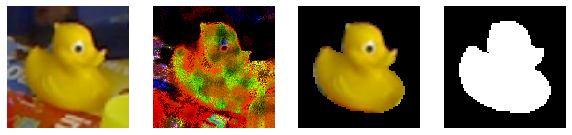

In [9]:
# Get specific test images
test_image, test_aug_image, test_rec, test_mask = real_test_data.__getitem__(15) # Convert to 4d tensor (BxNxHxW)
test_image = test_image.unsqueeze(0)
test_aug_image = test_aug_image.unsqueeze(0)
test_rec = test_rec.unsqueeze(0)

test_data_image = ((test_image - test_image.min()) / (test_image.max() - test_image.min()))
test_data_aug_image = ((test_aug_image - test_aug_image.min()) / (test_aug_image.max() - test_aug_image.min()))
test_data_rec = ((test_rec - test_rec.min()) / (test_rec.max() - test_rec.min()))

plt.figure(figsize=(10,10))
plt.subplot(1,4,1)
plt.imshow(test_data_image[0].permute(1,2,0))
plt.axis('off')
plt.subplot(1,4,2)
plt.imshow(test_data_aug_image[0].permute(1,2,0))
plt.axis('off')
plt.subplot(1,4,3)
plt.imshow(test_data_rec[0].permute(1,2,0))
plt.axis('off')
plt.subplot(1,4,4)
plt.imshow(test_mask[0],'gray')
plt.axis('off')

# Optimization

In [10]:
#shape invariant mean square error loss
def si_mse_loss(input, target):
    loss1 = ((input-target)**2).sum()/(input.view(-1).size()[0])
    loss2 = (((input-target).sum())**2)/((input.view(-1).size()[0])**2)
    loss = loss1 - loss2
    
    return loss
    
model = Net()
model.weight_init(mean=0.0, std=0.02)
model = nn.DataParallel(model)
model.to(device)

# setup optimizer
optimizer = optim.Adam(model.parameters(), lr=params['lr'])
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=params['epochs'], eta_min=0)

# Visualization

In [14]:
def visualization(model, test_path, rec_path, mask_path):
    model.eval()
    model.to(device)
    transform = transforms.Compose([
            transforms.Resize(size=params['input_size']),
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])     

    image = Image.open(test_path).convert("RGB")
    image = transform(image).unsqueeze_(0)
    rec, mask = model(image)
    rec = to_np(rec)
    rec = rec.squeeze()
    rec_out = (((rec - rec.min()) * 255) / (rec.max() - rec.min())).transpose(1, 2, 0).astype(np.uint8)

    mask = to_np(mask)
    mask = mask.squeeze()
    mask_out = np.where(mask>=params['threshold'], 1.0, 0)
    
    test_image = plt.imread(test_path)
    rec_image = plt.imread(rec_path)
    mask_image = plt.imread(mask_path)
    
    plt.figure(figsize=(15,15))
    display_list = [test_image, rec_image, rec_out, mask_image, mask_out]
    title = ['Input Image', 'Ground Truth(Rec)', 'Predicted Rec', 'Ground Truth(Mask)', 'Predicted Mask']
       
    for i in range(3):
        plt.subplot(1, 5, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i])
        plt.axis('off')
        
    for i in range(3,5):
        plt.subplot(1, 5, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i], 'gray')
        plt.axis('off')   
    plt.show()

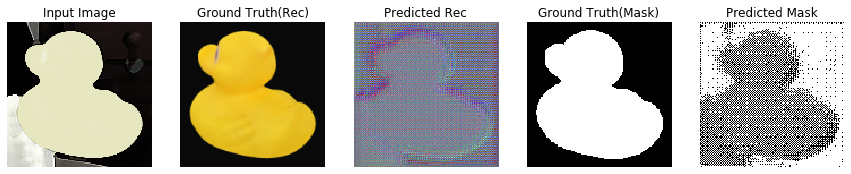

In [15]:
test_path = 'C:/Users/IVCL/Desktop/duck/aug_no_circle_margin/train/image/duck_00280.png'
rec_path = 'C:/Users/IVCL/Desktop/duck/aug_no_circle_margin/train/rec/duck_00280.png'
mask_path = 'C:/Users/IVCL/Desktop/duck/aug_no_circle_margin/train/label/duck_00280.png'
visualization(model, test_path, rec_path, mask_path)

# Training

In [16]:
checkpoint_path = './checkpoints_tc120_lm_fixmatch_reconstruction2_beta3_stride_aug'

In [ ]:
train_avg_rec_losses = []
val_avg_rec_losses = []
train_avg_mask_losses = []
val_avg_mask_losses = []
train_avg_u_losses = []
val_avg_u_losses = []

for epoch in range(params['epoch_count'], params['epochs'] + 1):
    # train
    model.to(device).train()
    
    train_rec_losses = []
    val_rec_losses = []
    train_mask_losses = []
    val_mask_losses = []
    train_u_losses = []
    val_u_losses = []
    
    scheduler.step()
    print('LR:', scheduler.get_lr())
    
    for iteration, (batch_sim, batch_real) in enumerate(zip(sim_train_data_loader, real_train_data_loader)):
        sim_img, sim_rec, sim_mask = batch_sim[0].to(device), batch_sim[1].to(device), batch_sim[2].to(device)
        real_img, real_aug_img, real_rec, real_mask = batch_real[0].to(device), batch_real[1].to(device), batch_real[2].to(device), batch_real[3].to(device)
        
        pre_sim_rec, pre_sim_mask = model(sim_img)
        pre_real_rec, pre_real_mask = model(real_img)
        pre_aug_real_rec, pre_aug_real_mask = model(real_aug_img)
        
        optimizer.zero_grad()
        
        # Loss s
        sim_mask_reverse = torch.ones(1,params['input_size'],params['input_size']).to(device) - sim_mask
        
        multiply = torch.mul(pre_sim_rec, sim_mask)
        multiply2 = torch.mul(pre_sim_rec, sim_mask_reverse)
        
        sim_rec2 = torch.mul(sim_rec, sim_mask_reverse)
        
        rec_loss1 = F.mse_loss(multiply, sim_rec)
        rec_loss2 = F.mse_loss(multiply2, sim_rec2)
        mask_loss = F.binary_cross_entropy(pre_sim_mask, sim_mask)
        
        rec_loss = rec_loss1*params['beta'] + rec_loss2
        
        loss_s = rec_loss + mask_loss

        # Loss u
        hat_pre_real_mask = torch.where(pre_real_mask>=params['tau'], torch.tensor(1.0).cuda(), torch.tensor(0.0).cuda())
        loss_u = F.binary_cross_entropy(pre_aug_real_mask, hat_pre_real_mask)
        
        # Total Loss
        loss = loss_s + loss_u*params['lamda_u']
        loss.backward()
        optimizer.step()
        
        # loss values
        train_rec_losses.append(rec_loss.item())
        train_mask_losses.append(mask_loss.item())
        train_u_losses.append(loss_u.item())

        if iteration % params['log_interval'] == 0:
            print("===> Epoch[{}/{}]({}/{}): Loss_Rec: {:.4f}  Loss_Mask: {:.4f}  Loss_U: {:.4f}".format(
                epoch, params['epochs'],iteration, len(real_train_data_loader), rec_loss.item(), mask_loss.item(),
                loss_u.item()))
    
    #for param_group in optimizer.param_groups:
    #    print('learning rate: {:.7f}'.format(param_group['lr']))
    
    # avg loss values for plot
    train_avg_rec_loss = torch.mean(torch.FloatTensor(train_rec_losses))
    train_avg_mask_loss = torch.mean(torch.FloatTensor(train_mask_losses))
    train_avg_u_loss = torch.mean(torch.FloatTensor(train_u_losses))
    
    train_avg_rec_losses.append(train_avg_rec_loss.item())
    train_avg_mask_losses.append(train_avg_mask_loss.item())
    train_avg_u_losses.append(train_avg_u_loss.item())
    
    model.to(device).eval()
    
    with torch.no_grad():
        for iteration, (batch_sim, batch_real) in enumerate(zip(sim_test_data_loader, real_test_data_loader)):
            sim_img, sim_rec, sim_mask = batch_sim[0].to(device), batch_sim[1].to(device), batch_sim[2].to(device)
            real_img, real_aug_img, real_rec, real_mask = batch_real[0].to(device), batch_real[1].to(device), batch_real[2].to(device), batch_real[3].to(device)

            pre_real_rec, pre_real_mask = model(real_img)
            pre_aug_real_rec, pre_aug_real_mask = model(real_aug_img)

            # Loss s
            real_mask_reverse = torch.ones(1,params['input_size'],params['input_size']).to(device) - real_mask

            multiply = torch.mul(pre_real_rec, real_mask)
            multiply2 = torch.mul(pre_real_rec, real_mask_reverse)

            real_rec2 = torch.mul(real_rec, real_mask_reverse)

            rec_loss1 = F.mse_loss(multiply, real_rec)
            rec_loss2 = F.mse_loss(multiply2, real_rec2)
            mask_loss = F.binary_cross_entropy(pre_real_mask, real_mask)

            rec_loss = rec_loss1*params['beta'] + rec_loss2

            loss_s = rec_loss + mask_loss

            # Loss u
            hat_pre_real_mask = torch.where(pre_real_mask>=params['tau'], torch.tensor(1.0).cuda(), torch.tensor(0.0).cuda())
            loss_u = F.binary_cross_entropy(pre_aug_real_mask, hat_pre_real_mask)

            # Total Loss
            loss = loss_s + loss_u*params['lamda_u'] 
            
            val_rec_losses.append(rec_loss.item())
            val_mask_losses.append(mask_loss.item())  
            val_u_losses.append(loss_u.item())
    
    # avg loss values for plot
    val_avg_rec_loss = torch.mean(torch.FloatTensor(val_rec_losses))
    val_avg_mask_loss = torch.mean(torch.FloatTensor(val_mask_losses))
    val_avg_u_loss = torch.mean(torch.FloatTensor(val_u_losses))
    
    val_avg_rec_losses.append(val_avg_rec_loss.item())
    val_avg_mask_losses.append(val_avg_mask_loss.item())
    val_avg_u_losses.append(val_avg_u_loss.item())
    
    print("Val_Loss_Rec: {:.4f}  Val_Loss_Mask: {:.4f}  Val_Loss_U: {:.4f}".format(
        val_avg_rec_loss.item(), val_avg_mask_loss.item(), val_avg_u_loss.item()))
    
    # Show result for test image
    image = test_image.cuda()
    rec = test_rec.cuda()
    mask = test_mask.cuda()
    pre_rec, pre_mask = model(image)
    
    plot_train_result([image, rec, pre_rec, mask, pre_mask], epoch, save=False)
    
    # Save weight
    if epoch % 1 == 0:
        torch.save(model.state_dict(), checkpoint_path+'/model-%s.pt'%epoch)
    
    # Plot loss
    if epoch % 10 == 0:
        plt.figure(figsize=(10,10))
        plt.subplot(3,1,1)
        plt.plot(train_avg_rec_losses, label='train')
        plt.plot(val_avg_rec_losses, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Reconstruction_Loss')
        plt.legend()

        plt.subplot(3,1,2)
        plt.plot(train_avg_mask_losses, label='train')
        plt.plot(val_avg_mask_losses, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('Mask_Loss')
        plt.legend()
        
        plt.subplot(3,1,3)
        plt.plot(train_avg_u_losses, label='train')
        plt.plot(val_avg_u_losses, label='val')
        plt.xlabel('Epoch')
        plt.ylabel('U_Loss')
        plt.legend()

In [20]:
print('Rec Loss :',np.array(val_avg_rec_losses).argmin()+1,
      '\tMask Loss :',np.array(val_avg_mask_losses).argmin()+1,
      '\tU Loss :',np.array(val_avg_u_losses).argmin()+1)

Rec Loss : 7 	Mask Loss : 9 	U Loss : 17


# Loss Curve

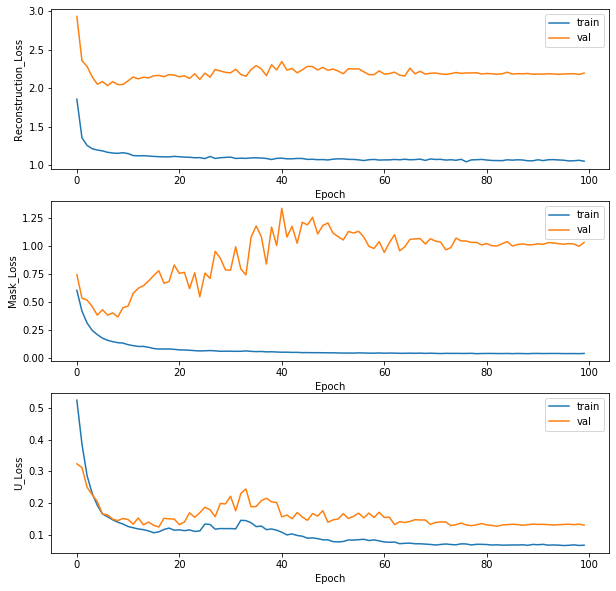

In [21]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(train_avg_rec_losses, label='train')
plt.plot(val_avg_rec_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction_Loss')
plt.legend()

plt.subplot(3,1,2)
plt.plot(train_avg_mask_losses, label='train')
plt.plot(val_avg_mask_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('Mask_Loss')
plt.legend()

plt.subplot(3,1,3)
plt.plot(train_avg_u_losses, label='train')
plt.plot(val_avg_u_losses, label='val')
plt.xlabel('Epoch')
plt.ylabel('U_Loss')
plt.legend()

# Restore Checkpoint

In [17]:
weight_dict = torch.load(checkpoint_path+'/model-16.pt')

In [18]:
model.load_state_dict(weight_dict)

<All keys matched successfully>

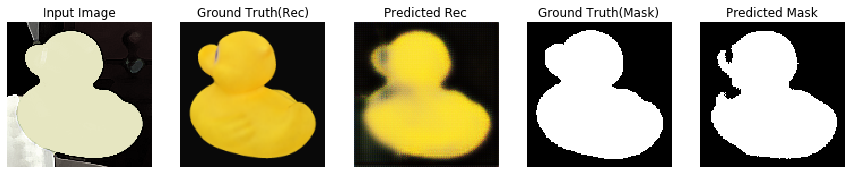

In [19]:
test_path = 'C:/Users/IVCL/Desktop/duck/aug_no_circle_margin/train/image/duck_00280.png'
rec_path = 'C:/Users/IVCL/Desktop/duck/aug_no_circle_margin/train/rec/duck_00280.png'
mask_path = 'C:/Users/IVCL/Desktop/duck/aug_no_circle_margin/train/label/duck_00280.png'
visualization(model, test_path, rec_path, mask_path)

In [ ]:
test_paths = glob('C:/Users/IVCL/Desktop/duck/real/test/image/*.png')

i = 0
for path in test_paths:
    rec_path = path[:-20]+'rec2/'+path[-14:]
    mask_path = path[:-20]+'label/'+path[-14:]
    i = i+1
    print('num_image :',i)
    visualization(model, path, rec_path, mask_path)

In [17]:
def precision(truth, pred):
    epsilon = 1e-7
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= 0.5, 1.0, 0)
    
    true_positive = np.sum(pred * truth)
    true_positive_false_positive = np.sum(pred)
    
    precision = true_positive / (true_positive_false_positive + epsilon)
                                 
    return precision

                                 
def recall(truth, pred):
    epsilon = 1e-7
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= 0.5, 1.0, 0)
    
    true_positive = np.sum(pred * truth)
    true_positive_false_negative =np.sum(truth)
    
    recall = true_positive / (true_positive_false_negative + epsilon)
                                 
    return recall

def accuracy(truth, pred):
    pred = pred.to('cpu').detach().numpy()
    truth = truth.to('cpu').detach().numpy()
    
    pred = np.where(pred >= 0.5, 1.0, 0)
    
    reversed_pred = 1 - pred
    reversed_truth = 1 - truth
    true_positive_true_negative = np.sum(pred * truth) + np.sum(reversed_pred * reversed_truth)
    
    accuracy = true_positive_true_negative / (np.sum(truth) + np.sum(reversed_truth))
                                 
    return accuracy

In [18]:
test_prec = 0
test_rec = 0
test_acc = 0
num_test = 0

model.to(device).eval()

for batch_idx, (data, aug_data, rec_target, mask_target) in enumerate(real_test_data_loader):
    data, aug_data, rec_target, mask_target = data.to(device), aug_data.to(device), rec_target.to(device), mask_target.to(device)
    rec_output, mask_output = model(data)
    test_prec += precision(mask_target, mask_output)
    test_rec += recall(mask_target, mask_output)
    test_acc += accuracy(mask_target, mask_output)
    num_test += 1
    
print('test_precision :',100. * test_prec / num_test, '\ttest_recall :', 100. * test_rec / num_test, '\ttest_accuracy :', 100 * test_acc / num_test)

test_precision : 95.0701442489668 	test_recall : 94.1524829735624 	test_accuracy : 95.57041368986431


In [19]:
test_mse = 0
num_test = 0
for batch_idx, (img, aug_img, rec, mask) in enumerate(real_test_data_loader):
    img, aug_img, rec, mask = img.to(device), aug_img.to(device), rec.to(device), mask.to(device)
    rec_output, mask_out = model(img)
    test_mse += F.mse_loss(rec_output, rec)
    num_test += 1
    
print('test_mse :',test_mse / num_test)

test_mse : tensor(0.1082, device='cuda:0', grad_fn=<DivBackward0>)
